# Using Sensitivity Analysis to Interrogate Models

Will Usher, UCL Energy Institute

10th December 2015

## How to use this notebook

There are several alternative ways in which you can use this notebook.
1. Access online here [![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/willu47/SATut) (changes won't be saved)
2. [Download](http://www.github.com/willu47/SATut) the notebooks, and install jupyter and python
    1. For Mac, open terminal and type
        `pip install jupyter notebook ipython`
    2. For Windows

# Agenda

1. What is Sensitivity Analysis?
1. Sensitivity Analysis Techniques
1. Some (Interactive) Examples
1. Summary

In [4]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(11, 9)

/Users/will2/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#  Introduction

## Uncertainty and Modelling

We use models to encode natural phenomena, to project and forecast, to understand, to learn.

Examples of models:
* discounted cash flow analysis
* [Gina coefficient](https://en.wikipedia.org/wiki/Gini_coefficient#Based_on_just_two_levels_of_income) (statistical measure of inequality)
* UKTM - energy system model of the United Kingdom
* [MetUM](http://www.metoffice.gov.uk/research/modelling-systems/unified-model) - UK weather forecasting

## What is Sensitivity Analysis?

“...the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.” 

There are two families of approaches:
* Local approaches
* Global approaches

### Characteristics of sensitivity and uncertainty analysis methods 

(adapted from Flechsig (2012), Saltelli(2008))

| Type | Morris | Variance | Factorial | Monte Carlo | Local SA |
|:------|------|------|------|------|------|
|Model independent? | yes | yes | yes | yes | yes|
|Sample source | levels | distributions | levels | distributions | levels |
|No. factors | $20-100$[1] | $<20$[1] | $>100$[1] | $<20$ | $<100$ |
|Factor range | global | global | global | global | local |
|Multi-factor variation | yes | yes | yes | yes | no |
|Correlated factors? | no | no | yes | yes | no |
|Cost (for k factors)? | $10(k+1)$ | $500(k+2)$ | $k \to 2k$ | $500+1$ | $2(k+1)$ |
|Estimated CPU time for ESME[2] | 1 day | 11 days | 3 hours | ~2 days | 1 hour |
  
[1] using groups of factors would enable larger numbers of factors to be explored
[2] assuming 5 minutes per simulation and 30 groups of factors

### Local versus Global Approaches

* Local approaches
    * e.g. one-at-a-time (OAT) approach
    * low data requirements
    * quick and easy to conduct
    * do not capture interactions between inputs
    * misleading for non-linear models


* Global approaches
    * e.g. Sobol analysis
    * often need probabilistic data
    * computationally demanding
    * capture interactions between inputs
    * handle non-linear and non-additive models

### Global Sensitivity Analysis

Screening approaches **rank** inputs according to their influence upon the output

Variance-based approaches **score** the sensitivity of each input with a numerical value, called the sensitivity index. Sensitivity indices come in several forms:
* First-order indices: measures the contribution to the output variance by a single model input alone.
* Second-order indices: measures the contribution to the output variance caused by the interaction of two model inputs.
* Total-order index: measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.

# Vehicle to Grid (V2G)

[Kempton (2005)](http://www.sciencedirect.com/science/article/pii/S0378775305000352) raise the prospect of using battery electric vehicles (BEVs) as mobile storage devices for electricity.  Other than pumped hydro, the electricity grid has virtually no storage devices.  Electricity storage could facilitate large capacities of variable output renewable technologies such as wind turbines and solar photovoltaics.

The concept of V2G is that electric the owners of electric (or even hydrogen fuel cell) vehicles could sacrifice some of their flexibility in return for hard cash by offering the use of their cars as giant batteries.


In [5]:
def max_vehicle_power(connector_power,
                      stored_energy,
                      distance_driven,
                      range_buffer,
                      dispatch_time,
                      driving_efficiency=4.025,
                      inverter_efficiency=0.93
                      ):
    '''
    Computed the maximum electrical power output of a vehicle in
    vehicle-to-grid
    
    Arguments:
        stored_energy - energy available as DC kWh to the invertor
        distance_driven - distance driven in km since energy storage full
        range_buffer - minimum range required by the driver in km
        driving_efficiency - 4.025 km/kWh
        inverter_efficiency - electrical conversion efficiency of DC to AC
                              inverter (93%)
        dispatch_time - time over which the vehicle's stored energy 
                        is dispatched in hours
    
    Returns:
        the minimum of the connector_power and maximum power for V2G in kW
    '''


    max_vehicle_power = ((stored_energy - \
                         ((distance_driven + range_buffer) \
                         / driving_efficiency)) * inverter_efficiency) \
                         / dispatch_time
    
    return np.maximum(0, np.minimum(connector_power, max_vehicle_power))

In [6]:
@interact(connector=widgets.FloatSlider(value=3.0, min=1.5, max=14, step=0.5), 
          battery_size=widgets.FloatSlider(value=30, min=10, max=100, step=10), 
          distance_driven=widgets.FloatSlider(value=0, min=0, max=100, step=5), 
          range_buffer=widgets.FloatSlider(value=0, min=0, max=100, step=10))
def plot_power(connector, battery_size, distance_driven, range_buffer):
    dispatch_time = 8
    return max_vehicle_power(connector,
                      battery_size,
                      distance_driven,
                      range_buffer,
                      dispatch_time
                      )

5.379270186335404

In [7]:
def monte_carlo(data):
    dispatch_time = 8
    y = max_vehicle_power(data[0], data[1], data[2], data[3], dispatch_time)
    return y

def monte_carlo_large(data):
    dispatch_time = 8
    y = max_vehicle_power(data[0], data[1], data[2], data[3], dispatch_time, data[4], data[5])
    return y

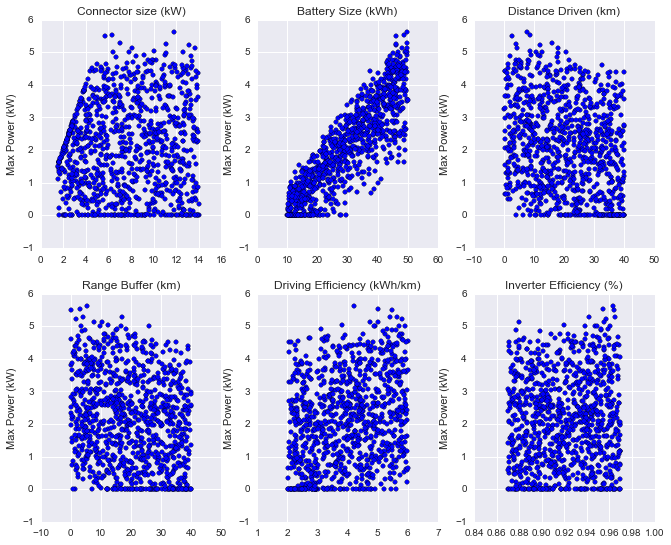

In [24]:
number_sims = 1000

# Make some random data in the correct ranges
mc_connector = np.random.uniform(1.5, 14, number_sims)
mc_battery_size = np.random.uniform(10, 50, number_sims)
mc_distance_driven = np.random.uniform(0, 40, number_sims)
mc_range_buffer = np.random.uniform(0, 40, number_sims)
mc_driving_eff = np.random.uniform(2, 6, number_sims)
mc_inv_eff = np.random.uniform(0.87, 0.97, number_sims)

data = np.array((mc_connector, mc_battery_size, mc_distance_driven, mc_range_buffer, mc_driving_eff, mc_inv_eff))

# Run the code
y = monte_carlo_large(data)

# Make some scatter plots to compare the results
plt.subplot(231)
plt.scatter(mc_connector, y)
plt.title("Connector size (kW)")
plt.ylabel("Max Power (kW)")
plt.subplot(232)
plt.scatter(mc_battery_size, y)
plt.title("Battery Size (kWh)")
plt.ylabel("Max Power (kW)")
plt.subplot(233)
plt.scatter(mc_distance_driven, y)
plt.title("Distance Driven (km)")
plt.ylabel("Max Power (kW)")
plt.subplot(234)
plt.scatter(mc_range_buffer, y)
plt.title("Range Buffer (km)")
plt.ylabel("Max Power (kW)")
plt.subplot(235)
plt.scatter(mc_driving_eff, y)
plt.title("Driving Efficiency (kWh/km)")
plt.ylabel("Max Power (kW)")
plt.subplot(236)
plt.scatter(mc_inv_eff, y)
plt.title("Inverter Efficiency (%)")
plt.ylabel("Max Power (kW)")

# Using SALib to run a Sensitivity Analysis

SALib is a **free** **open-source** **Python** library

If you use Python, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))


## Define a problem file

In the code below, a problem file is used to define the variables we wish to explore

In [9]:
from SALib.sample import morris as ms

In [10]:
problem = {
    'num_vars': 6,
    'names': ['conn', 'batt', 'dist', 'range', 'dri_eff', 'inv_eff'],
    'bounds': [[1.5, 14],
               [10, 50],
               [0, 40],
              [0, 40],
              [2,6],
              [0.87,0.97]],
    'groups': None
    }

sample = ms.sample(problem, 100, num_levels=4, grid_jump=2)

We'll run a sensitivity analysis of this power "model"

In [11]:
output = monte_carlo_large(sample.T)
from SALib.analyze import morris
Si = morris.analyze(problem, sample, output)

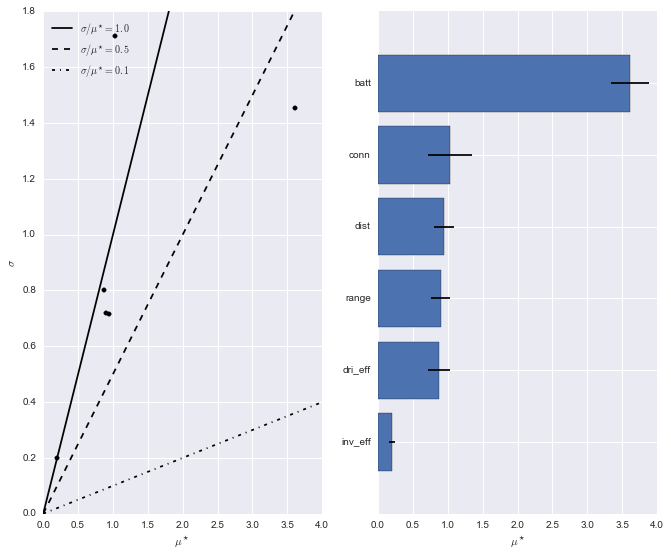

In [12]:
from SALib.plotting import morris as mp

fig, (ax1, ax2) = plt.subplots(1, 2)
p = mp.covariance_plot(ax1, Si, {})
p = mp.horizontal_bar_plot(ax2, Si)

In [13]:
def battery_lifetime(lifetime_cycles,
                     total_energy_stored,
                     depth_of_discharge
                    ):
    '''
    Compute the lifetime of a battery in energy terms
    
    Arguments:
        lifetime_cycles - 
        total_energy_stored - size of battery (kWh)
        depth_of_discharge - the depth of discharge for which 
                            lifetime_cycles is defined (0 <= DoD <= 1)
    
    Returns:
        battery_lifetime in energy terms - units: kWh
    
    '''
    lifetime = lifetime_cycles * total_energy_stored * depth_of_discharge
    return lifetime

In [14]:
rav4e = battery_lifetime(2000, 27.4, 0.8)

In [15]:
rav4e

43840.0

In [16]:
def annualized_capital_cost(cost, discount_rate, lifetime):
    '''
    Arguments:
        cost - in GBP2015
        discount_rate - %
        lifetime - in years
    '''
    ann_cc = cost * (discount_rate / (1-(1+discount_rate)**-lifetime))
    return ann_cc

In [17]:
annualized_capital_cost(1900, 0.1, 10)

309.2162502767719

In [18]:
def compute_profit():

    time_dispatched = 8000 # hours

    battery_size = 27.4 # kWh
    battery_unit_cost = 350 # £/kWh

    connector_power = 14 # kW

    battery_capital_cost = battery_size * battery_unit_cost # 2015£
    lifetime_cycles = 2000
    depth_of_discharge = 0.8

    electricity_price = 0.2 # £/kWh - sell when its expensive
    purchased_energy_cost = 0.05 # £/kWh - buy when it's cheap

    round_trip_efficiency = 0.73 # 73% efficiency grid-battery-grid

    cost_of_v2g_equip = 2000
    discount_rate = 0.1 # 10%
    economic_lifetime = 10

    stored_energy = battery_size * depth_of_discharge # kWh
    distance_driven = 0 # km
    range_buffer = 10 # km

    power_available = max_vehicle_power(connector_power,
                                        stored_energy,
                                        distance_driven,
                                        range_buffer,
                                        8,
                                        )

    energy_dispatched = power_available * time_dispatched

    revenue = electricity_price * energy_dispatched

    cost = cost_of_vehicle_to_grid(battery_capital_cost,
                                   lifetime_cycles,
                                   battery_size,
                                   depth_of_discharge,
                                   purchased_energy_cost,
                                   round_trip_efficiency,
                                   energy_dispatched,
                                   cost_of_v2g_equip,
                                   discount_rate,
                                   economic_lifetime)

    if revenue > cost:
        profit = revenue - cost
    else:
        profit = 0

    return profit, revenue, cost

In [19]:
compute_profit()

NameError: name 'cost_of_vehicle_to_grid' is not defined

In [ ]:
def cost_of_vehicle_to_grid(battery_capital_cost,
                            lifetime_cycles,
                            total_energy_stored,
                            depth_of_discharge,
                            purchased_energy_cost,
                            round_trip_efficiency,
                            energy_dispatched,
                            cost_of_v2g_equip,
                            discount_rate,
                            economic_lifetime):
    
    battery_life = battery_lifetime(lifetime_cycles,
                                    total_energy_stored,
                                    depth_of_discharge
                                    )
    
    degredation_cost = battery_capital_cost / battery_life
    
    cost_of_energy = (purchased_energy_cost / round_trip_efficiency) \
                        + degredation_cost
    
    annualised_capex = annualized_capital_cost(cost_of_v2g_equip, 
                                               discount_rate, 
                                               economic_lifetime)
    
    cost = (cost_of_energy * energy_dispatched) + annualised_capex
    
    return cost